# Panel

https://panel.holoviz.org/index.html

In [ ]:
# pip install panel

Panel lets you add interactive controls for just about anything you can display in Python. Panel can help you build simple interactive apps, complex multi-page dashboards, or anything in between. As a simple example, let’s say we have loaded the UCI ML dataset measuring the environment in a meeting room:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('occupancy.csv')
data['date'] = data.date.astype('datetime64[ns]')
data = data.set_index('date')

data.tail()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-18 09:15:00,20.815,27.7175,429.75,1505.25,0.004213,1
2015-02-18 09:16:00,20.865,27.7450,423.50,1514.50,0.004230,1
2015-02-18 09:16:59,20.890,27.7450,423.50,1521.50,0.004237,1
2015-02-18 09:17:59,20.890,28.0225,418.75,1632.00,0.004279,1
2015-02-18 09:19:00,21.000,28.1000,409.00,1864.00,0.004321,1


And we’ve written some code that smooths a time series and plots it using Matplotlib with outliers highlighted:

In [4]:
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas

%matplotlib inline

def mpl_plot(avg, highlight):
    fig = Figure()
    FigureCanvas(fig) # not needed in mpl >= 3.1
    ax = fig.add_subplot()
    avg.plot(ax=ax)
    if len(highlight): highlight.plot(style='o', ax=ax)
    return fig

def find_outliers(variable='Temperature', window=30, sigma=10, view_fn=mpl_plot):
    avg = data[variable].rolling(window=window).mean()
    residual = data[variable] - avg
    std = residual.rolling(window=window).std()
    outliers = (np.abs(residual) > std * sigma)
    return view_fn(avg, avg[outliers])

We can call the function with parameters and get a plot:

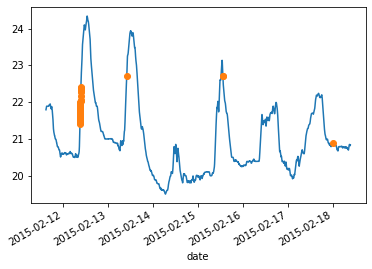

In [5]:
find_outliers(variable='Temperature', window=20, sigma=10)

It works! But exploring all these parameters by typing Python is slow and tedious. Plus we want our boss, or the boss’s boss, to be able to try it out.

If we wanted to try out lots of combinations of these values to understand how the window and sigma affect the plot, we could reevaluate the above cell lots of times, but that would be a slow and painful process, and is only really appropriate for users who are comfortable with editing Python code. In the next few examples we will demonstrate how to use Panel to quickly add some interactive controls to some object and make a simple app.

To see an overview of the different APIs Panel offers see the API user guide and for a quick reference for various Panel functionality see the overview.
https://panel.holoviz.org/index.html

### Interactive Panels

Instead of editing code, it’s much quicker and more straightforward to use sliders to adjust the values interactively. You can easily make a Panel app to explore a function’s parameters using pn.interact, which is similar to the ipywidgets interact function:

Column
    [0] Column
        [0] IntSlider(end=90, name='window', start=-30, value=30)
        [1] IntSlider(end=30, name='sigma', start=-10, value=10)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00101')
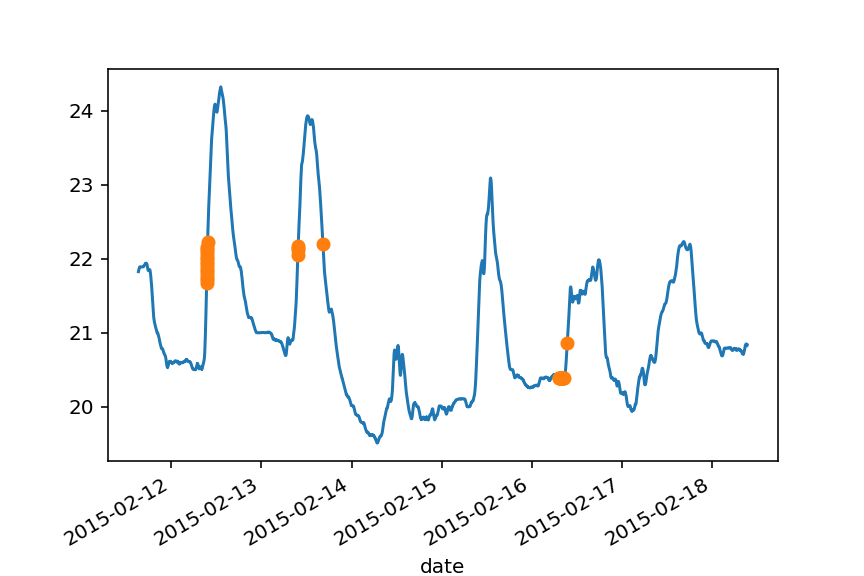

In [6]:
import panel as pn
pn.extension()

pn.interact(find_outliers)

As long as you have a live Python process running, dragging these widgets will trigger a call to the find_outliers callback function, evaluating it for whatever combination of parameter values you select and displaying the results. A Panel like this makes it very easy to explore any function that produces a visual result of a supported type, such as Matplotlib (as above), Bokeh, Plotly, Altair, or various text and image types.

### Components of Panels

interact is convenient, but what if you want more control over how it looks or works? First, let’s see what interact actually creates, by grabbing that object and displaying its representation:

In [7]:
kw = dict(window=(1, 60), variable=sorted(list(data.columns)), sigma=(1, 20))
i = pn.interact(find_outliers, **kw)
i.pprint()

Column
    [0] Column
        [0] Select(name='variable', options=['CO2', 'Humidity', ...], value='Temperature')
        [1] IntSlider(end=60, name='window', start=1, value=30)
        [2] IntSlider(end=20, name='sigma', start=1, value=10)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00114')


As you can see, the interact call created a pn.Column object consisting of a WidgetBox (with 3 widgets) and a pn.Row with one Matplotlib figure object. Panel is compositional, so you can mix and match these components any way you like, adding other objects as needed:

Row
    [0] Matplotlib(Figure, name='interactive00114')
    [1] Column
        [0] Markdown(str)
        [1] Select(name='variable', options=['CO2', 'Humidity', ...], value='Temperature')
        [2] IntSlider(end=60, name='window', start=1, value=30)
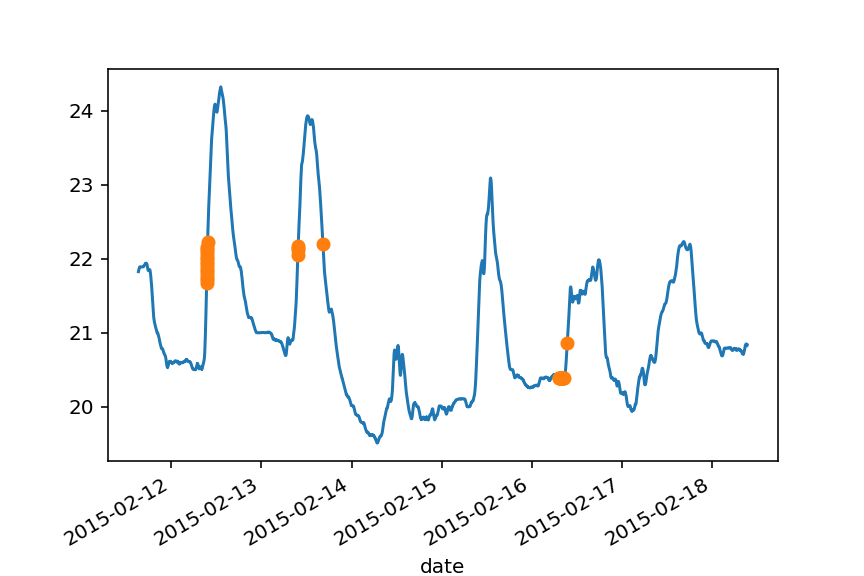

In [8]:
text = "<br>\n# Room Occupancy\nSelect the variable, and the time window for smoothing"

p = pn.Row(i[1][0], pn.Column(text, i[0][0], i[0][1]))
p

Note that the widgets stay linked to their plot even if they are in a different notebook cell:

In [9]:
i[0][2]

IntSlider(end=20, name='sigma', start=1, value=10)

Also note that Panel widgets are reactive, so they will update even if you set the values by hand:

In [10]:
i[0][2].value = 5

### Composing new Panels

You can use this compositional approach to combine different components such as widgets, plots, text, and other elements needed for an app or dashboard in arbitrary ways. The interact example builds on a reactive programming model, where an input to the function changes and Panel reactively updates the output of the function. interact is a convenient way to create widgets from the arguments to your function automatically, but Panel also provides a more explicit reactive API letting you specifically define connections between widgets and function arguments, and then lets you compose the resulting dashboard manually from scratch.

In the example below we explicitly declare each of the components of an app: widgets, a function to return the plot, column and row containers, and the completed occupancy Panel app. Widget objects have multiple “parameters” (current value, allowed ranges, and so on), and here we will use Panel’s bind function to declare that function’s input values should come from the widgets’ value parameters. Now when the function and the widgets are displayed, Panel will automatically update the displayed output whenever any of the inputs change:

Row
    [0] ParamFunction(function)
    [1] Column
        [0] Markdown(str)
        [1] RadioButtonGroup(name='variable', options=['Temperature', ...], value='Temperature')
        [2] IntSlider(end=60, name='window', start=1, value=10)
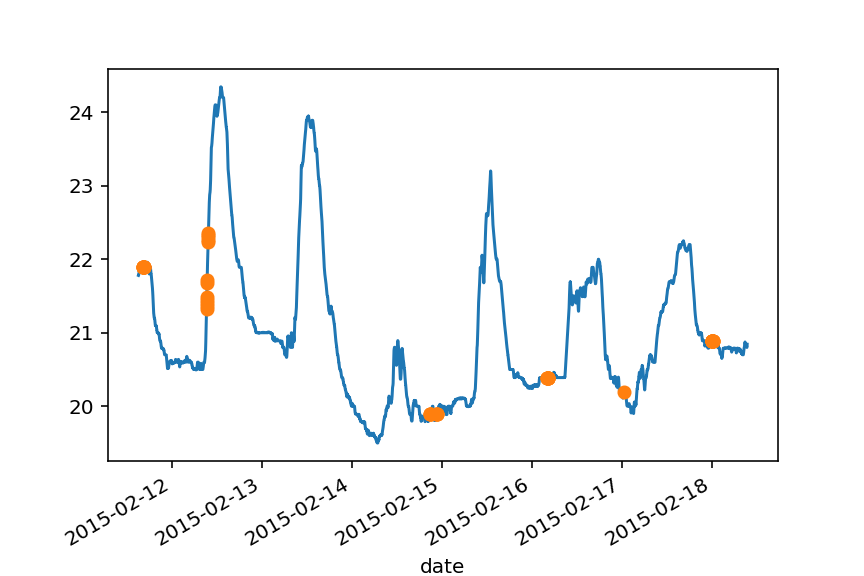

In [11]:
import panel.widgets as pnw

variable  = pnw.RadioButtonGroup(name='variable', value='Temperature', 
                                 options=list(data.columns))
window  = pnw.IntSlider(name='window', value=10, start=1, end=60)

reactive_outliers = pn.bind(find_outliers, variable, window, 10)

widgets   = pn.Column("<br>\n# Room occupancy", variable, window)
occupancy = pn.Row(reactive_outliers, widgets)
occupancy

### Declarative Panels

The above compositional approach is very flexible, but it ties your domain-specific code (the parts about sine waves) with your widget display code. That’s fine for small, quick projects or projects dominated by visualization code, but what about large-scale, long-lived projects, where the code is used in many different contexts over time, such as in large batch runs, one-off command-line usage, notebooks, and deployed dashboards? For larger projects like that, it’s important to be able to separate the parts of the code that are about the underlying domain (i.e. application or research area) from those that are tied to specific display technologies (such as Jupyter notebooks or web servers).

For such usages, Panel supports objects declared with the separate Param library, which provides a GUI-independent way of capturing and declaring the parameters of your objects (and dependencies between your code and those parameters), in a way that’s independent of any particular application or dashboard technology. For instance, the above code can be captured in an object that declares the ranges and values of all parameters, as well as how to generate the plot, independently of the Panel library or any other way of interacting with the object:

In [12]:
import param

class RoomOccupancy(param.Parameterized):
    variable  = param.Selector(objects=list(data.columns))
    window    = param.Integer(default=10, bounds=(1, 20))
    sigma     = param.Number(default=10, bounds=(0, 20))

    def view(self):
        return find_outliers(self.variable, self.window, self.sigma)
    
obj = RoomOccupancy()
obj

RoomOccupancy(name='RoomOccupancy00147', sigma=10, variable='Temperature', window=10)

The RoomOccupancy class and the obj instance have no dependency on Panel, Jupyter, or any other GUI or web toolkit; they simply declare facts about a certain domain (such as that smoothing requires window and sigma parameters, and that window is an integer greater than 0 and sigma is a positive real number). This information is then enough for Panel to create an editable and viewable representation for this object without having to specify anything that depends on the domain-specific details encapsulated in obj:

Row
    [0] Column(margin=5, name='RoomOccupancy', width=300)
        [0] StaticText(value='<b>RoomOccupancy</b>')
        [1] Select(name='Variable', options=OrderedDict([('Temperature...]), value='Temperature')
        [2] IntSlider(end=20, name='Window', start=1, value=10)
        [3] FloatSlider(end=20, name='Sigma', value=10)
    [1] ParamMethod(method)
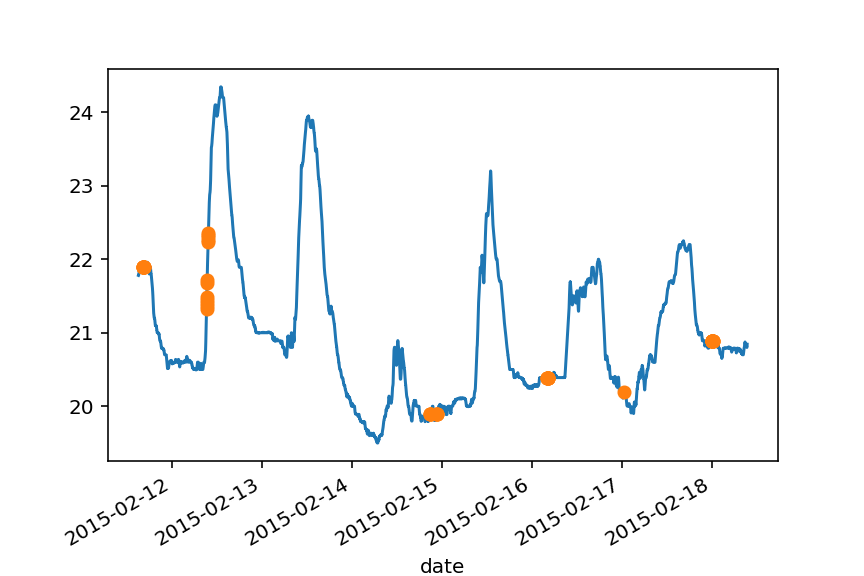

In [13]:
pn.Row(obj.param, obj.view)

To support a particular domain, you can create hierarchies of such classes encapsulating all the parameters and functionality you need across different families of objects, with both parameters and code inheriting across the classes as appropriate, all without any dependency on a particular GUI library or even the presence of a GUI at all. This approach makes it practical to maintain a large codebase, all fully displayable and editable with Panel, in a way that can be maintained and adapted over time.

### Linking plots and actions between panes

he above approaches each work with a very wide variety of displayable objects, including images, equations, tables, and plots. In each case, Panel provides interactive functionality using widgets and updates the displayed objects accordingly, while making very few assumptions about what actually is being displayed. Panel also supports richer, more dynamic interactivity where the displayed object is itself interactive, such as the JavaScript-based plots from Bokeh and Plotly.

For instance, if we substitute the Bokeh wrapper hvPlot for the Matplotlib wrapper provided with Pandas, we automatically get interactive plots that allow zooming, panning and hovering:

In [ ]:
#pip install hvplot

In [15]:
import hvplot.pandas

def hvplot(avg, highlight):
    return avg.hvplot(height=200) * highlight.hvplot.scatter(color='orange', padding=0.1)

text2 = "## Room Occupancy\nSelect the variable and the smoothing values"
hvp   = pn.interact(find_outliers, view_fn=hvplot, **kw)
pn.Column(pn.Row(pn.panel(text2, width=400), hvp[0]), hvp[1]).servable("Occupancy")

Column
    [0] Row
        [0] Markdown(str, width=400)
        [1] Column
            [0] Select(name='variable', options=['CO2', 'Humidity', ...], value='Temperature')
            [1] IntSlider(end=60, name='window', start=1, value=30)
            [2] IntSlider(end=20, name='sigma', start=1, value=10)
    [1] Row
        [0] HoloViews(Overlay, name='interactive01618')

These interactive actions can be combined with more complex interactions with a plot (e.g. tap, hover) to make it easy to explore data more deeply and uncover connections. For instance, we can use HoloViews to make a more full-featured version of the hvPlot example that displays a table of the current measurement values at the hover position on the plot:

In [ ]:
#pip install holoviews

In [17]:
import holoviews as hv

tap = hv.streams.PointerX(x=data.index.min())

def hvplot2(avg, highlight):
    line = avg.hvplot(height=300, width=500)
    outliers = highlight.hvplot.scatter(color='orange', padding=0.1)
    tap.source = line
    return (line * outliers).opts(legend_position='top_right')

@pn.depends(tap.param.x)
def table(x):
    index = np.abs((data.index - x).astype(int)).argmin()
    return data.iloc[index]

app = pn.interact(find_outliers, view_fn=hvplot2, **kw)

pn.Row(
    pn.Column("## Room Occupancy\nHover over the plot for more information.", app[0]),
    pn.Row(app[1], table)
)

C:\Users\Anna\AppData\Local\Temp/ipykernel_14000/2286378374.py:13: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  index = np.abs((data.index - x).astype(int)).argmin()


Row
    [0] Column
        [0] Markdown(str)
        [1] Column
            [0] Select(name='variable', options=['CO2', 'Humidity', ...], value='Temperature')
            [1] IntSlider(end=60, name='window', start=1, value=30)
            [2] IntSlider(end=20, name='sigma', start=1, value=10)
    [1] Row
        [0] Row
            [0] HoloViews(Overlay, name='interactive02203')
        [1] ParamFunction(function)